# Demonstration of Rossby waves phase and group speeds

We demonstrate here the difference between Rossby phase speed and the Rossby group velocity on a barotropic beta-plane.

Rossby waves obey the dispersion relation

$$
\omega(\boldsymbol{k}) = -\frac{\beta k_x}{k_x^2+k_y^2}
$$

This dispersion relation implies that the Rossby phase speed is:

$$
{\boldsymbol{c}}_{\rm phase} = \big( \frac{\omega}{k_x}, \frac{\omega}{k_y} \big) =  -\frac{\beta}{k^2} \big( 1 , \tan(\pi/2-\theta)\big)
$$

where $k\equiv |\boldsymbol{k}|$ and angle $\theta$ is the angle formed by wavevector $\boldsymbol{k}$ and the horizontal,  defined through $\tan\theta = k_y/k_x$. 

The phase speed is *always* facing westwards, i.e., $c_{\rm phase,x}<0$. The phase speed ${\boldsymbol{c}}_{\rm phase}$ forms an angle $\pi/2-\theta$ with the horizontal.

The group speed, on the other hand, is given through:

$$
{\boldsymbol{c}}_{\rm group} = \big( \frac{\partial\omega}{\partial k_x}, \frac{\partial\omega}{\partial k_y} \big) =  \frac{\beta}{k^2}\big(\cos 2\theta, \sin 2\theta\big),
$$

and thus generally is in a diffent direction compared to $\boldsymbol{c}_{\rm phase}$.

The figure below demonstrates the relation of $\boldsymbol{k}$, $\boldsymbol{c}_{\rm phase}$, and $\boldsymbol{c}_{\rm group}$.

<img src="assets/rossbydispersion.png" width=85%>

In [1]:
using Pkg
Pkg.activate("../.")

using GeophysicalFlows, PyPlot

import GeophysicalFlows.SingleLayerQG
import FFTW: rfft, irfft, fftshift
import LinearAlgebra: norm

  Activating environment at `~/Research/FourierFlows/GeophysicalFlows-Examples/Project.toml`
┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /Users/navid/.julia/packages/FourierFlows/tVoz9/src/FourierFlows.jl:123


In [2]:
# Numerical parameters and time-stepping parameters
nx  = 128      # 2D resolution = nx^2
stepper = "FilteredETDRK4"   # timestepper
dt  = 0.25     # timestep
nsteps = 100   # total number of time-steps
nsubs  = 1     # number of time-steps for plotting
               # (nsteps must be multiple of nsubs)

# Physical parameters
Lx = 2π      # domain size
 β = 15.0    # planetary PV gradient

# Initialize problem
prob = SingleLayerQG.Problem(nx=nx, Lx=Lx, β=β, dt=dt, stepper=stepper)
sol, cl, v, p, g = prob.sol, prob.clock, prob.vars, prob.params, prob.grid

x, y = gridpoints(g);

Now let's construct a gaussian vorticity wavepacket:
    
$$
 \zeta(x, y, t=0) =  \mathrm{Re}\big[ \zeta_0\,e^{-(x^2+y^2)/(2\sigma^2)} e^{\mathrm{i}(k_{x0} x+ k_{y0} y)} \big].
$$

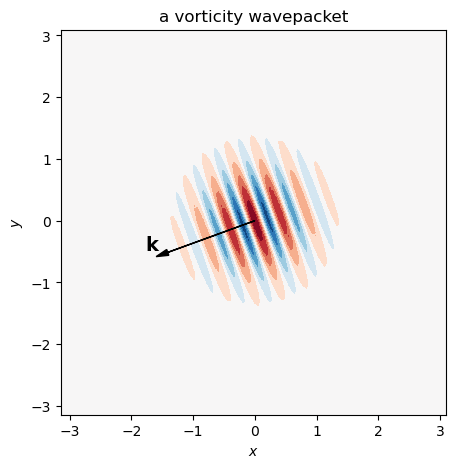

In [3]:
k = 15                         # total wavenumber
θ = 200*pi/180                 # wavevector's angle (in radians)
kx0, ky0 = k*cos(θ), k*sin(θ)  # the wavevector
ω = -β*kx0/k^2              # the Rossby frequeency

ζ0 = 1e-7 # wave amplitude; small amplitude to ensure linearity

σ = Lx/10 # gaussian envelopes variance

ζ = @. real(ζ0*exp(-(x^2+y^2)/(2σ^2))*exp(im*(kx0*x+ky0*y)))

maxvalue = maximum(abs.(ζ))
levels = range(-maxvalue, maxvalue, length=12)


figure(figsize=(5, 5))
contourf(x, y, ζ, levels, cmap="RdBu_r")

arrow(0, 0, 1.5*kx0/k, 1.5*ky0/k, head_width=0.1, head_length=0.2, fc="k", ec="k")
text(1.9*kx0/k, 1.4*ky0/k, L"$\mathbf{k}$", color="k", fontsize=14)

axis("square")
xlabel(L"$x$")
ylabel(L"$y$")
title("a vorticity wavepacket");

Our wavepacket resembles the configuration depicted in the left panel of the figure above. 

The Rossby frequency, phase speed, group speed that correspond to our wavenumber choice are:

In [4]:
cphase = @. [ω/kx0, ω/ky0]
cgroup = @. [β*(kx0^2-ky0^2)/k^4, 2*β*kx0*ky0/k^4]

println("β = ", round(β, digits=2))
println("ω = ", round(ω, digits=2))
println("k = (", round(kx0, digits=2), ", ", round(ky0, digits=2), ")")
println("c_phase = (", round(cphase[1], digits=2), ", ", round(cphase[2], digits=2), ")")
println("c_group = (", round(cgroup[1], digits=2), ", ", round(cgroup[2], digits=2), ")")

β = 15.0
ω = 0.94
k = (-14.1, -5.13)
c_phase = (-0.07, -0.18)
c_group = (0.05, 0.04)


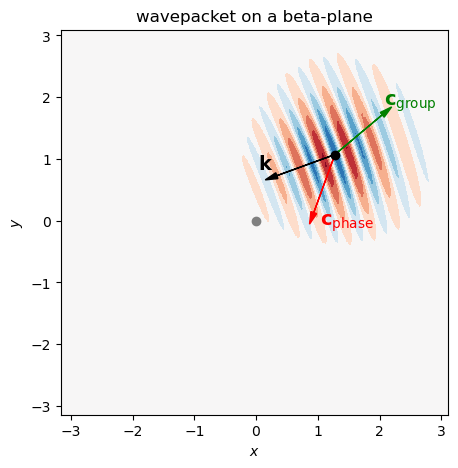

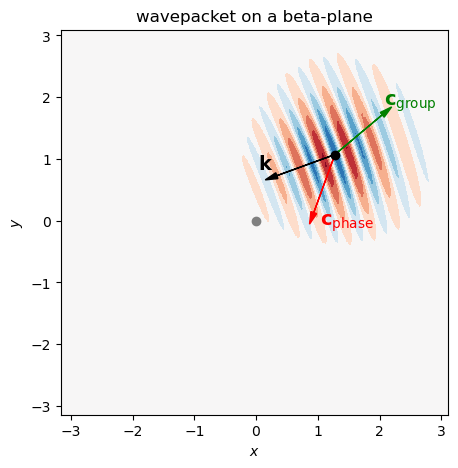

In [5]:
SingleLayerQG.set_q!(prob, ζ)  # setting the initial condition in our barotropic QG model

fig = figure(figsize=(5, 5))

while cl.step < nsteps
    stepforward!(prob, nsubs) 
    ζ = irfft(sol, g.nx)
    t = cl.t
    
    # plot ζ(x, y, t) and the k, c_phase, c_group vectors
    cla()
    IJulia.clear_output(true)
    contourf(x, y, ζ, levels, cmap="RdBu_r")
    
    plot(0, 0, "o", linewidth=2, markersize=6, color="gray")
    plot(cgroup[1]*t, cgroup[2]*t, "o", linewidth=2, markersize=6, color="black")
    
    arrow(t*cgroup[1], t*cgroup[2], cgroup[1]/norm(cgroup), cgroup[2]/norm(cgroup), head_width=0.1, head_length=0.2, fc="g", ec="g")
    text(cgroup[1]*t+0.8, cgroup[2]*t+0.8, L"$\mathbf{c}_{\rm group}$", color="g", fontsize=14)
    
    arrow(t*cgroup[1], t*cgroup[2], cphase[1]/norm(cphase), cphase[2]/norm(cphase), head_width=0.1, head_length=0.2, fc="r", ec="r")
    text(cphase[1]/norm(cphase) + cgroup[1]*t+0.1, cphase[2]/norm(cphase) + cgroup[2]*t-0.2, L"$\mathbf{c}_{\rm phase}$", color="r", fontsize=14)

    arrow(t*cgroup[1], t*cgroup[2], kx0/k, ky0/k, head_width=0.1, head_length=0.2, fc="k", ec="k")
    text(kx0/k + cgroup[1]*t-0.3, ky0/k + cgroup[2]*t+0.1, L"$\mathbf{k}$", color="k", fontsize=14)
    
    axis("equal")
    xlabel(L"$x$")
    ylabel(L"$y$")
    title("wavepacket on a beta-plane")
    display(fig);
end